# Programming Assignment 4 - Pegasos: Sub-gradient Descent Algorithm for Softmargin Primal SVM

In this assignment, you will perform handwritten digit classification using the MNIST dataset of handwritten digits. Each example represents an image of a digit (size $28\times 28$) that has been been flattened into a feature vector of length $784$. Each feature specifies a grayscale pixel value.

You will apply SVMs to automatically classify the digits. Note: we will be using a simplified multiclass one-vs-rest approach. (While you will not transform the data in this assignment, please note that SVMs can classify digits with a $1.1\%$ error rate if we applied a degree 4 polynomial transformation to the data.) 

This assignment has 3 components:
* Step 1: Implement the Pegasos algorithm to perform binary classification. You will be asked to distinguish a handwritten 0 from any other handwritten digit. 
* Step 2: Perform multiclass classification using the Pegasos binary classification algorithm you wrote in step 1. You will use a simplified one-vs-rest approach to automatically classify digits.
* Step 3: Try different hyperparameters to see if you can improve the accuracy of automatically classifying digits. Please include a short writeup describing the techniques you used and the effectiveness of each of them. 

In [1]:
# import the necessary libraries
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Loading the dataset

In [2]:
# Read in the dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print("Number of examples:", X.shape)

c:\Python310\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of examples: (70000, 784)


## Preparing the dataset

We will next perform 3 preprocessing steps before running the classifier:

* Split the datset into training and testing sets
* Scale the training and test set
* For step 1, we encode the '0' labels to be +1, and the non-zero labels to '-1'. 


###  Split the dataset into a training, validation and test set.

In [3]:
# Splitting the dataset 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)

In [4]:
# Check to make sure everything is as expected
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))


X_train:(60542, 784)
y_train:(60542,)
X_val: 	(4557, 784)
y_val: 	(4557,)
X_test: (4901, 784)
y_test: (4901,)


### Looking at 4 training examples

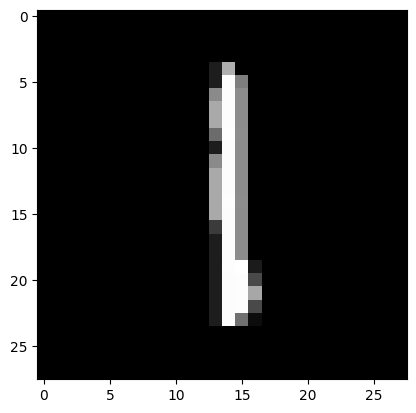

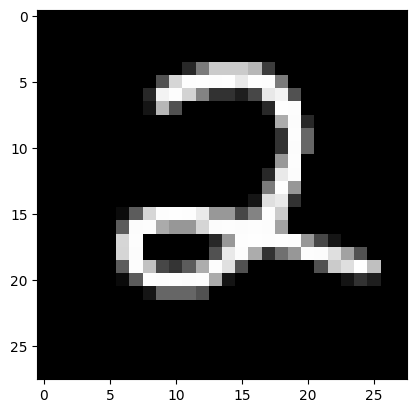

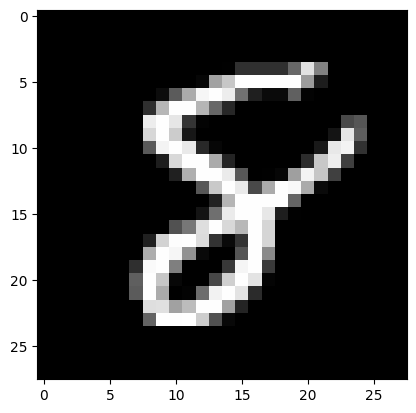

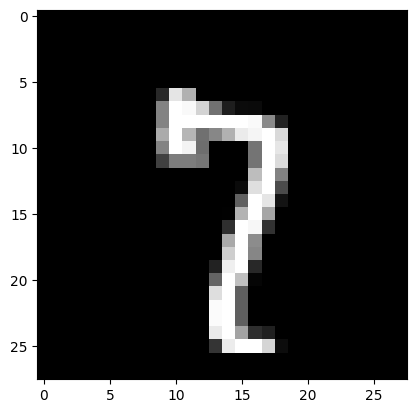

In [5]:
# What the examples looks like. Note, the feature  vector was rescaled to be 28x28
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [6]:
# Normalizing the features, so each feature is in the range [-1,1].  
# In this datset, each feature has a minimum value of 0 and a maximum value of 255.
X_train = 2*X_train/255 -1
X_val = 2*X_val/255-1
X_test = 2*X_test/255-1

### Looking at 4 training examples after scaling

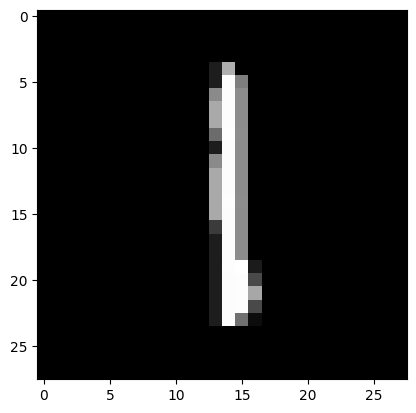

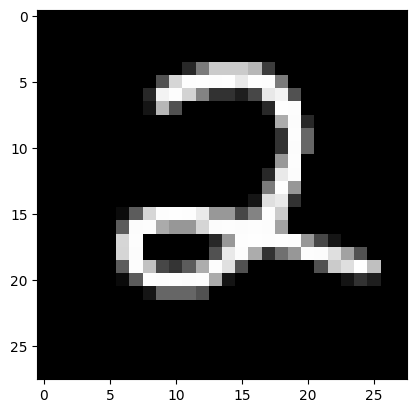

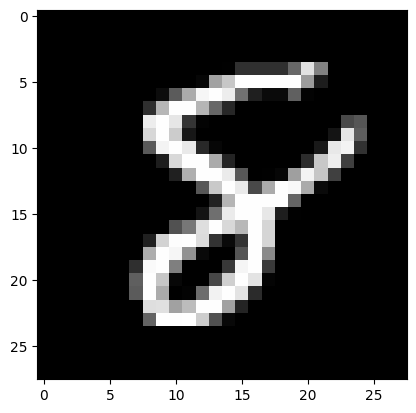

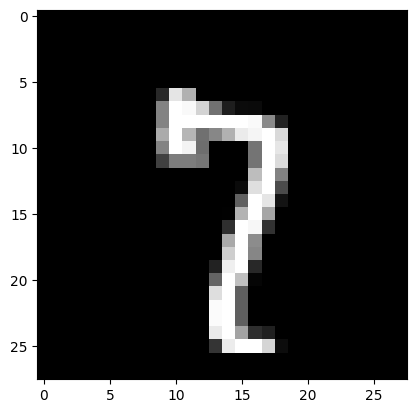

In [7]:
# What the dataset looks like after scaling
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

# Step 1: Binary Classification Using the Pegasos algorithm

Before writing the Pegasos algorithm, we will write 3 helper functions:

First, we will need a preprocessing step to encode the labels so that:
* one class has label 1 
* the other class has label -1

Second, we will write the function that computes $X{\bf w}$

Third, we will write the function that computes the objective function. During the Pegasos subgradient descent algorithm, we will look at how the function is changing


### Encoding function.  We will use this function in step 1 and step 2.

In [8]:
# The original labels are '1', '2', ... '9'. Our SVM algorithm Pegasos expects the labels to be encoded as +1 and -1
# Here we encode one digit as 1, and we encode the other 9 digits as -1
def one_vs_rest_encoding(y, digit = '0'):

    # Let y_encoded be an numpy array of encoded digits, with 1 for the digit we want to predict, and -1 for the rest
    # This may take several lines of code, but please store your final encoding in y_encoded
    y_encoded = np.where(y == digit, 1, -1)
    
    return  y_encoded


In [9]:
# Perform the encoding for step 1's task
y_train_0_vs_rest = one_vs_rest_encoding(y_train, '0')
y_val_0_vs_rest =  one_vs_rest_encoding(y_val, '0')

### Write the function $score(X,w)$ that computes $X{\bf w}$

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix

In [10]:
# Compute the score for each example in X
def score(X, w):
    # To do
    return np.dot(X, w)


### Write the SVM objective function: 
$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$.  You don't need to include $w_0$ in your objective function.

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix
* $\bf y$ is the target vector

In [11]:
def svm_objective(w, X, y, lambda1=.1):
    # To do. This part may require several lines of code. 
    # Store your answer in result.
    result = 0.5 * lambda1 * np.dot(w, w.T) + np.sum(np.maximum(0, 1 - y * score(X, w)))
    return result

### Write the Pegasos binary classification algorithm


* `X_train`  is the design matrix 
* `y_train`  is the target vector
* `lambda1` is the tuning parameter. Note we couldn't call it lambda, since lambda is a reserved word in python.


The update step is:

$
\text{if } y^{(i)}({\bf w}^T{\bf x}^{(i)}\ge 1)  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha\lambda {\bf w}\\
\text{else }  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha(\lambda {\bf w}-y^{(i)}{\bf x}^{(i)})
$

In [12]:
# stochastic sub-gradient descent
def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):
    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    np.random.seed(10)
    randoms = np.random.randint(0, N, size=(num_iters, N))
    for iter in range(num_iters):
     
        print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train, lambda1)))

        for i in range (N):
            r = randoms[iter][i]
            t = t + 1
            alpha = 1/(lambda1*t)
            # Complete the following code to find w. This will require several lines of code. 
            if (y_train[r] * np.dot(w, X_train[r]) >= 1):
                w = w - alpha * lambda1 * w
            else:
                w = w - alpha * (lambda1 * w - (y_train[r] * X_train[r]))
        
    return w

## Step 2: Multiclass Classification
Implement multi-class prediction using one-versus-all classification.

### First: Train 10 binary classifiers using the Pegasos algorithm from the previous question.
For each digit you will create a classifier:
* Relabel labels equal to the digit to 1
* Relabel the other 9 labels to -1
* Use the Pegasos algorithm to get the weight vector (the classifier)

Following this step, you will have 10 distinct weight vectors.

### Second: Predict the label of the validation set.
To predict the label of a single example ${\bf x}$:
* Compute the dot product of ${\bf x}$ with each weight vector. You will have 10 scores (one for each classifier).
* Predict the label corresponding to the class that had the maximum score.

Note this is a simple method for choosing the label. For a more sophisticated approach read: https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=One%20standard%20way%20to%20obtain,validation%20on%20the%20training%20data.

### Third: Find the accuracy of the classifier based on the validation set 
For each label, observe how the classifier performed on the validation set. 

In [13]:
# Create the 10 classifiers
labels = "0123456789"
w_vals= {}
val_scores = {}
lam = 0.005
num_iters = 10
for i in range(len(labels)):
    # Note that each section may require more than one line of code.
    
    # Perform one-vs-rest for labels[i]
    # To do: Relabel the y labels in the train set to either 1 or -1 using one_vs_rest_encoding
    y_encoded = one_vs_rest_encoding(y_train, labels[i])
    # To do: Use the Pegasos algorithm on X_train and y_encoded to get the weight vector
    w_vals[i] = pegasos(X_train, y_encoded, lam, num_iters)
    
    # Estimate accuracy for one-vs-rest classifier for labels[i]
    # To do:  Relabel the y labels in the validation set to either 1 or -1 using one_vs_rest_encoding
    y_encoded_val = one_vs_rest_encoding(y_val, labels[i])
    # To do: Accuracy Estimation for one-vs-rest classifier for labels[i]
    guesses = np.where(score(X_val, w_vals[i]) > 0.5, 1, -1)
    correct = np.sum(guesses == y_encoded_val)
    val_scores[i] = correct / len(y_encoded_val)

Iteration 0. J: 3063314.885490
Iteration 1. J: 1819.878949
Iteration 2. J: 1754.827924
Iteration 3. J: 1412.512793
Iteration 4. J: 1507.320983
Iteration 5. J: 1623.573507
Iteration 6. J: 1401.360853
Iteration 7. J: 1501.574580
Iteration 8. J: 1409.584936
Iteration 9. J: 1404.618585
Iteration 0. J: 4537885.183529
Iteration 1. J: 1711.632572
Iteration 2. J: 1541.508939
Iteration 3. J: 1529.113369
Iteration 4. J: 1677.176722
Iteration 5. J: 1500.005523
Iteration 6. J: 1580.151831
Iteration 7. J: 1583.899712
Iteration 8. J: 1413.497554
Iteration 9. J: 1408.894055
Iteration 0. J: 3308095.203137
Iteration 1. J: 4918.065046
Iteration 2. J: 3766.770581
Iteration 3. J: 3521.823085
Iteration 4. J: 3532.842522
Iteration 5. J: 3416.262160
Iteration 6. J: 3501.745754
Iteration 7. J: 3573.594483
Iteration 8. J: 3873.960039
Iteration 9. J: 3480.346719
Iteration 0. J: 3450140.991373
Iteration 1. J: 5719.098479
Iteration 2. J: 5065.611432
Iteration 3. J: 4396.246067
Iteration 4. J: 7982.901347
Iteratio

In [14]:
# Check your work. With the proper amount of iterations, your values should range from 0.95 to 0.99  
for i in range(len(labels)):
     print(i,": score:", val_scores[i])

0 : score: 0.989466754443713
1 : score: 0.9899056396752249
2 : score: 0.978494623655914
3 : score: 0.9747640991880623
4 : score: 0.9734474434935264
5 : score: 0.9653280667105552
6 : score: 0.9806890498134738
7 : score: 0.9824445907395216
8 : score: 0.9578670177748518
9 : score: 0.9545753785385122


In [15]:
# To do: Predict the label for each example in the validation set 
# We will let eval be a numpy array of length N, where N is the number of examples in the validation set. 
# eval1 will hold either a 1 or a 0, depending if the handwritten digit was predicted correctly or not.
eval1 = np.zeros((len(y_val)))

# To do: Loop through each sample in the validation set and assign it a label based on the highest score. 
# Store either a 1 if the number was predicted correctly, or a 0 if the number was predicted incorrectly.
for i, sample in enumerate(X_val):
    scores = np.zeros((len(w_vals)))
    for j in range(len(scores)):
        scores[j] = score(sample, w_vals[j])
    guess = np.argmax(scores)
    eval1[i] = (guess == int(y_val[i]))
eval1 = np.where(eval1 == True, 1, 0)


In [16]:
# To do: Determine how many were predicted correctly (Find its accuracy score)
accuracy = np.sum(eval1) / len(eval1)
print("Accuracy Score:",accuracy)

Accuracy Score: 0.9098090849242922


# Step 3: Hyper-parameter Choices

* See if you can find better hyper-parameter settings
* Once you have found the best settings, rerun the algorithm using the data from both validation and training sets.
* Evaluate your performance on the test data.
* In a markdown comment, please discuss the techniques you used. You may discuss how you found your hyper-parameters, if the techniques worked/didn't work, etc. Please be concise. We are expecting this to be a short paragraph in length. 


I found my hyperparameters by simply testing various values for each on their own and choosing the ones that gave the best scores. After about 10 iterations the model seemed to wander around and do worse, so I left it at 10. A lambda any bigger or smaller than 0.005 also seemed to perform worse than 0.005, so I went with that one. Using these hyperparameters to train on the validation and training set gave an accuracy of 90.6% when tested on the test set, which is similar to what was obtained when training on only the training test and testing on the validation set.

In [17]:
# Combining training and validation tests
X_super_train = np.vstack((X_train, X_val))
y_super_train = np.hstack((y_train, y_val))

# Getting weights

labels = "0123456789"
w_vals= {}
val_scores = {}
lam = 0.005
num_iters = 10
for i in range(len(labels)):
    print("\nTraining classifier for label: ", labels[i])

    y_encoded = one_vs_rest_encoding(y_super_train, labels[i])
    w_vals[i] = pegasos(X_super_train, y_encoded, lam, num_iters)
    
    y_encoded_val = one_vs_rest_encoding(y_test, labels[i])

    guesses = np.where(score(X_test, w_vals[i]) > 0.5, 1, -1)
    correct = np.sum(guesses == y_encoded_val)
    val_scores[i] = correct / len(y_encoded_val)

# Getting accuracy

test = np.zeros((len(y_test)))

for i, sample in enumerate(X_test):
    scores = np.zeros((len(w_vals)))
    for j in range(len(scores)):
        scores[j] = score(sample, w_vals[j])
    guess = np.argmax(scores)
    test[i] = (guess == int(y_test[i]))
test = np.where(test == True, 1, 0)

accuracy = np.sum(test) / len(test)
print("Accuracy Score:", accuracy)


Training classifier for label:  0
Iteration 0. J: 3276644.771765
Iteration 1. J: 2013.845634
Iteration 2. J: 1619.618839
Iteration 3. J: 1780.992624
Iteration 4. J: 1506.226461
Iteration 5. J: 1802.192520
Iteration 6. J: 1603.230792
Iteration 7. J: 1488.853369
Iteration 8. J: 1513.458328
Iteration 9. J: 1471.527912

Training classifier for label:  1
Iteration 0. J: 4872766.465882
Iteration 1. J: 1814.960572
Iteration 2. J: 2959.809177
Iteration 3. J: 1723.658299
Iteration 4. J: 1540.448512
Iteration 5. J: 1603.856900
Iteration 6. J: 1549.567661
Iteration 7. J: 1715.801092
Iteration 8. J: 1526.901830
Iteration 9. J: 1496.324689

Training classifier for label:  2
Iteration 0. J: 3569040.575686
Iteration 1. J: 4696.235529
Iteration 2. J: 5034.533151
Iteration 3. J: 3728.061861
Iteration 4. J: 3919.274737
Iteration 5. J: 4231.294160
Iteration 6. J: 3664.589165
Iteration 7. J: 3730.007749
Iteration 8. J: 3573.355870
Iteration 9. J: 3566.627879

Training classifier for label:  3
Iteration 0